In [1]:
import os
os.environ["SPARK_HOME"] = "/home/atimaby28/spark-3.5.0-bin-hadoop3"

import findspark
findspark.init()

In [2]:
import pyspark
sc = pyspark.SparkContext(appName="AirBnb")

24/02/12 15:53:17 WARN Utils: Your hostname, bigdata-project resolves to a loopback address: 127.0.1.1; using 192.168.64.7 instead (on interface enp0s1)
24/02/12 15:53:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/12 15:53:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

/home/atimaby28/spark-3.5.0-bin-hadoop3/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
hdfs_path = "hdfs://localhost:9000/user/atimaby28/"
file_path = hdfs_path + "airbnb_data.csv"

df_air = sqlContext.read.format("csv").option("header", "true").option("inferSchema", "false").load(file_path)

df_air.show(10)

+--------+--------+---------------+-------+-------------+-------+--------------------+------------+--------+-----+-------+---------+----------+--------------------+
| room_id| host_id|      room_type|borough| neighborhood|reviews|overall_satisfaction|accommodates|bedrooms|price|minstay| latitude| longitude|       last_modified|
+--------+--------+---------------+-------+-------------+-------+--------------------+------------+--------+-----+-------+---------+----------+--------------------+
| 6291807|16375951|Entire home/apt|   NULL|Jamaica Plain|      1|                NULL|           4|     2.0|119.0|   14.0| 42.29816| -71.11153|2016-05-19 02:58:...|
| 2656568|13597630|Entire home/apt|   NULL|     Back Bay|      0|                NULL|           2|     1.0|600.0|    1.0|42.348072|-71.076639|2016-05-19 02:58:...|
|10723203|15913699|   Private room|   NULL|      Allston|      2|                NULL|           2|     1.0| 96.0|    1.0|42.350588|-71.129477|2016-05-19 02:57:...|
|10034592|

In [5]:
from pyspark.sql.functions import col

df_air.where(col("borough").isNotNull()).show()

+-------+-------+---------+-------+------------+-------+--------------------+------------+--------+-----+-------+--------+---------+-------------+
|room_id|host_id|room_type|borough|neighborhood|reviews|overall_satisfaction|accommodates|bedrooms|price|minstay|latitude|longitude|last_modified|
+-------+-------+---------+-------+------------+-------+--------------------+------------+--------+-----+-------+--------+---------+-------------+
+-------+-------+---------+-------+------------+-------+--------------------+------------+--------+-----+-------+--------+---------+-------------+



In [6]:
df_air = df_air.na.fill(value="unknown", subset=["borough"])
df_air.where(col("borough").isNotNull()).show()                

+--------+--------+---------------+-------+-------------+-------+--------------------+------------+--------+-----+-------+---------+----------+--------------------+
| room_id| host_id|      room_type|borough| neighborhood|reviews|overall_satisfaction|accommodates|bedrooms|price|minstay| latitude| longitude|       last_modified|
+--------+--------+---------------+-------+-------------+-------+--------------------+------------+--------+-----+-------+---------+----------+--------------------+
| 6291807|16375951|Entire home/apt|unknown|Jamaica Plain|      1|                NULL|           4|     2.0|119.0|   14.0| 42.29816| -71.11153|2016-05-19 02:58:...|
| 2656568|13597630|Entire home/apt|unknown|     Back Bay|      0|                NULL|           2|     1.0|600.0|    1.0|42.348072|-71.076639|2016-05-19 02:58:...|
|10723203|15913699|   Private room|unknown|      Allston|      2|                NULL|           2|     1.0| 96.0|    1.0|42.350588|-71.129477|2016-05-19 02:57:...|
|10034592|

In [7]:
from pyspark.sql.types import IntegerType, DoubleType, StringType

df = df_air.select(df_air.neighborhood,
                   df_air.room_id.cast(IntegerType()),
                   df_air.host_id.cast(IntegerType()),
                   df_air.reviews.cast(DoubleType()),
                   df_air.overall_satisfaction.cast(DoubleType()),
                   df_air.accommodates.cast(DoubleType()),
                   df_air.bedrooms.cast(DoubleType()),
                   df_air.price.cast(DoubleType())
                  )

In [8]:
df = df.na.fill(value=3, subset=["overall_satisfaction"])
df.show(10)

+-------------+--------+--------+-------+--------------------+------------+--------+-----+
| neighborhood| room_id| host_id|reviews|overall_satisfaction|accommodates|bedrooms|price|
+-------------+--------+--------+-------+--------------------+------------+--------+-----+
|Jamaica Plain| 6291807|16375951|    1.0|                 3.0|         4.0|     2.0|119.0|
|     Back Bay| 2656568|13597630|    0.0|                 3.0|         2.0|     1.0|600.0|
|      Allston|10723203|15913699|    2.0|                 3.0|         2.0|     1.0| 96.0|
|   Dorchester|10034592|20399668|   13.0|                 5.0|         2.0|     1.0| 55.0|
|     Back Bay| 5454513| 4962900|   13.0|                 4.5|         5.0|     2.0|276.0|
|  East Boston|  335730|  290698|   34.0|                 3.5|         9.0|     1.0| 70.0|
|  Beacon Hill| 7635616|22348222|    3.0|                 5.0|         2.0|     0.0|155.0|
|      Allston|12808014|28197086|    0.0|                 3.0|         1.0|     1.0| 65.0|

In [9]:
df1 = df

df1 = df1.withColumn("total_score", df1["overall_satisfaction"] + df1["reviews"] * 0.378)
df1 = df1.select("room_id", "host_id", "total_score")

df1.show(10)

+--------+--------+------------------+
| room_id| host_id|       total_score|
+--------+--------+------------------+
| 6291807|16375951|             3.378|
| 2656568|13597630|               3.0|
|10723203|15913699|3.7560000000000002|
|10034592|20399668|             9.914|
| 5454513| 4962900|             9.414|
|  335730|  290698|            16.352|
| 7635616|22348222|             6.134|
|12808014|28197086|               3.0|
| 6793913|30283594|3.7560000000000002|
|  586994| 2894162|22.266000000000002|
+--------+--------+------------------+
only showing top 10 rows



In [10]:
df1.sort("total_score", ascending=True).write.csv("./result/airbnb/sorted_total_score_ascending")
df1.sort("total_score", ascending=False).write.csv("./result/airbnb/sorted_total_score_descending")

---

In [11]:
import pyspark.sql.functions as F

df2 = df

df2 = df.groupBy("neighborhood").agg(F.mean("reviews").alias("avg of reviews"),
                                     F.mean("overall_satisfaction").alias("avg of overall_satisfaction"),
                                     F.mean("price").alias("avg of price"),
                                     F.max("reviews").alias("max of reviews"),
                                     F.min("reviews").alias("min of reviews"),
                                     F.max("price").alias("max of price"),
                                     F.min("price").alias("min of price")
                                    ).sort("neighborhood")

df2.show(10)

+------------+------------------+---------------------------+------------------+--------------+--------------+------------+------------+
|neighborhood|    avg of reviews|avg of overall_satisfaction|      avg of price|max of reviews|min of reviews|max of price|min of price|
+------------+------------------+---------------------------+------------------+--------------+--------------+------------+------------+
|     Allston| 10.31400966183575|          3.710144927536232|100.01932367149759|         118.0|           0.0|       550.0|        20.0|
|    Back Bay|11.296819787985866|         3.9558303886925796|237.51590106007066|         283.0|           0.0|      1372.0|        41.0|
| Bay Village|10.947368421052632|         3.9473684210526314| 254.1578947368421|          47.0|           0.0|      1200.0|        81.0|
| Beacon Hill|              17.8|          4.087804878048781|215.90731707317073|         214.0|           0.0|       849.0|        42.0|
|    Brighton|             13.25|        

In [12]:
df2.write.csv("./result/airbnb/grouped_neighborhood_ascend")

In [13]:
df2.rdd.getNumPartitions()

1

In [14]:
df2.coalesce(1).write.csv("./result/airbnb/grouped_partition1")

df2.coalesce(1).write.option("header", "True").format("csv").save(hdfs_path + "output_df2")

---

In [15]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import udf

df3 = df

bucketizer = Bucketizer(splits=[0, 100, 200, 300, 400, 500, 1000, 5000], inputCol="price", outputCol="buckets")
df3_buck = bucketizer.setHandleInvalid("keep").transform(df3)

df3_buck.show(10)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+-------------+--------+--------+-------+--------------------+------------+--------+-----+-------+
| neighborhood| room_id| host_id|reviews|overall_satisfaction|accommodates|bedrooms|price|buckets|
+-------------+--------+--------+-------+--------------------+------------+--------+-----+-------+
|Jamaica Plain| 6291807|16375951|    1.0|                 3.0|         4.0|     2.0|119.0|    1.0|
|     Back Bay| 2656568|13597630|    0.0|                 3.0|         2.0|     1.0|600.0|    5.0|
|      Allston|10723203|15913699|    2.0|                 3.0|         2.0|     1.0| 96.0|    0.0|
|   Dorchester|10034592|20399668|   13.0|                 5.0|         2.0|     1.0| 55.0|    0.0|
|     Back Bay| 5454513| 4962900|   13.0|                 4.5|         5.0|     2.0|276.0|    2.0|
|  East Boston|  335730|  290698|   34.0|                 3.5|         9.0|     1.0| 70.0|    0.0|
|  Beacon Hill| 7635616|22348222|    3.0|                 5.0|         2.0|     0.0|155.0|    1.0|
|      All

In [16]:
scope = {0.0 : "0-100", 1.0 : "100-200", 2.0 : "200-300", 3.0 : "300-400", 4.0 : "400-500", 5.0 : "500-1000", 6.0 : "1000-2000"}
udf_scope = udf(lambda x : scope[x], StringType())
df3_buck = df3_buck.withColumn("price_range", udf_scope("buckets"))

df3_buck.select("room_id", "price", "buckets", "price_range").show()

+--------+-----+-------+-----------+
| room_id|price|buckets|price_range|
+--------+-----+-------+-----------+
| 6291807|119.0|    1.0|    100-200|
| 2656568|600.0|    5.0|   500-1000|
|10723203| 96.0|    0.0|      0-100|
|10034592| 55.0|    0.0|      0-100|
| 5454513|276.0|    2.0|    200-300|
|  335730| 70.0|    0.0|      0-100|
| 7635616|155.0|    1.0|    100-200|
|12808014| 65.0|    0.0|      0-100|
| 6793913|571.0|    5.0|   500-1000|
|  586994|160.0|    1.0|    100-200|
| 1373520|125.0|    1.0|    100-200|
| 4369766|170.0|    1.0|    100-200|
| 9992532|571.0|    5.0|   500-1000|
| 1187188|240.0|    2.0|    200-300|
| 5824015| 50.0|    0.0|      0-100|
| 9992751|199.0|    1.0|    100-200|
| 9362821| 83.0|    0.0|      0-100|
|  213086| 70.0|    0.0|      0-100|
| 8388481| 89.0|    0.0|      0-100|
|   95453|175.0|    1.0|    100-200|
+--------+-----+-------+-----------+
only showing top 20 rows



In [17]:
df3_buck = df3_buck.groupBy("buckets", "price_range").agg(F.mean("accommodates").alias("avg of accommodates"),
                                                          F.expr("percentile_approx(accommodates, 0.5)").alias("median accommodates"),
                                                          F.mean("bedrooms").alias("avg of bedrooms"),
                                                          F.expr("percentile_approx(bedrooms, 0.5)").alias("median bedrooms"),
                                                          F.mean("reviews").alias("avg of reviews"),
                                                          F.expr("percentile_approx(reviews, 0.5)").alias("median reviews"),
                                                          F.collect_list("neighborhood").alias("neighborhood")
                                                         ).sort("buckets", ascending=True).drop("buckets")

df3_buck.show(13)

+-----------+-------------------+-------------------+------------------+---------------+-------------------+--------------+--------------------+
|price_range|avg of accommodates|median accommodates|   avg of bedrooms|median bedrooms|     avg of reviews|median reviews|        neighborhood|
+-----------+-------------------+-------------------+------------------+---------------+-------------------+--------------+--------------------+
|      0-100|  1.974025974025974|                2.0|0.9897959183673469|            1.0| 21.000927643784788|           5.0|[Allston, Dorches...|
|    100-200| 2.9757869249394675|                2.0|1.1011326860841424|            1.0| 17.102502017756255|           5.0|[Jamaica Plain, B...|
|    200-300| 3.8719298245614033|                4.0| 1.536412078152753|            1.0| 13.719298245614034|           4.0|[Back Bay, Jamaic...|
|    300-400|  4.812182741116751|                5.0|  2.00507614213198|            2.0|  9.309644670050762|           4.0|[South 

In [18]:
df3_output = df3_buck.select('*', F.size('neighborhood').alias('length'))
df3_output.show()

+-----------+-------------------+-------------------+------------------+---------------+-------------------+--------------+--------------------+------+
|price_range|avg of accommodates|median accommodates|   avg of bedrooms|median bedrooms|     avg of reviews|median reviews|        neighborhood|length|
+-----------+-------------------+-------------------+------------------+---------------+-------------------+--------------+--------------------+------+
|      0-100|  1.974025974025974|                2.0|0.9897959183673469|            1.0| 21.000927643784788|           5.0|[Allston, Dorches...|  1078|
|    100-200| 2.9757869249394675|                2.0|1.1011326860841424|            1.0| 17.102502017756255|           5.0|[Jamaica Plain, B...|  1239|
|    200-300| 3.8719298245614033|                4.0| 1.536412078152753|            1.0| 13.719298245614034|           4.0|[Back Bay, Jamaic...|   570|
|    300-400|  4.812182741116751|                5.0|  2.00507614213198|            2.0|

In [19]:
import matplotlib.pyplot as plt
import pandas

/tmp/ipykernel_15905/3116011920.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


Text(0, 0.5, 'accommodates average')

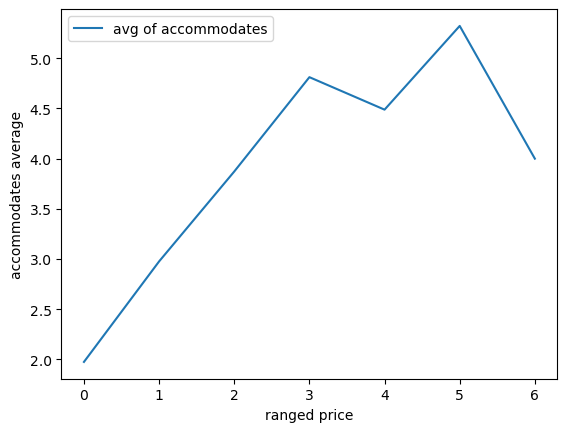

In [20]:
df3_local = df3_output.toPandas()

table1 = df3_local[["avg of accommodates"]]
table1.plot.line()
plt.xlabel("ranged price")
plt.ylabel("accommodates average")